In [78]:
using Base.Threads
println("Number of threads: ", nthreads())


# To set threads for paralel chains go to command prompt 
# see how many threads are available on the CPU with:
# "wmic cpu get NumberOfLogicalProcessors"
# Set the number of threads you want to use with:
# "set JULIA_NUM_THREADS=6 (6 as an example)"
# Then open julia with threads in vs code with:
# "code ."


Number of threads: 1


In [79]:
include("import_packages.jl")

# Load the model to estimate
# includet("models/ar1_cycle.jl")
# includet("models/ar1_cycle_no_noise.jl")
# includet("models/wave_cycle.jl")
# includet("models/wave_cycle_no_noise.jl")
includet("models/wave_cycle_stochastic_drift.jl")
# includet("models/wave_cycle_stochastic_drift_no_noise.jl")
# includet("models/wave_cycle_deterministic_drift.jl")
# includet("models/multivariate_wave_cycle_stochastic_drift.jl")
# includet("models/multivariate_wave_cycle_stochastic_drift_no_noise.jl")
# includet("models/AR2StochasticDrift.jl")

includet("State_Space_Model.jl")
using .state_space_model

includet("Kalman.jl")
using .kalman

includet("Particle.jl")
using .ParticleFilter

includet("MCMC.jl")
using .MCMC

includet("MLE.jl")
using .MLE







## Data

276×4 DataFrame
 Row │ observation_date  π          y         u       
     │ String15          Float64    Float64   Float64 
─────┼────────────────────────────────────────────────
   1 │ 4/1/1955           0.0        3069.91      4.7
   2 │ 7/1/1955           0.499376   3111.38      4.0
   3 │ 10/1/1955          0.124224   3130.07      4.3
   4 │ 1/1/1956          -0.248139   3117.92      4.0
   5 │ 4/1/1956           0.870647   3143.69      4.0
   6 │ 7/1/1956           1.23305    3140.87      4.4
   7 │ 10/1/1956          0.609013   3192.57      3.9
   8 │ 1/1/1957           0.605327   3213.01      4.2
  ⋮  │        ⋮              ⋮         ⋮         ⋮
 270 │ 7/1/2022           1.31466   22066.8       3.5
 271 │ 10/1/2022          0.367161  22249.5       3.6
 272 │ 1/1/2023           1.04491   22403.4       3.5
 273 │ 4/1/2023           1.19233   22539.4       3.4
 274 │ 7/1/2023           0.866427  22780.9       3.5
 275 │ 10/1/2023          0.104508  22960.6       3.9
 276 │ 1/1/2024           1.04258   23053.5       3.7
                                      261 rows omitted

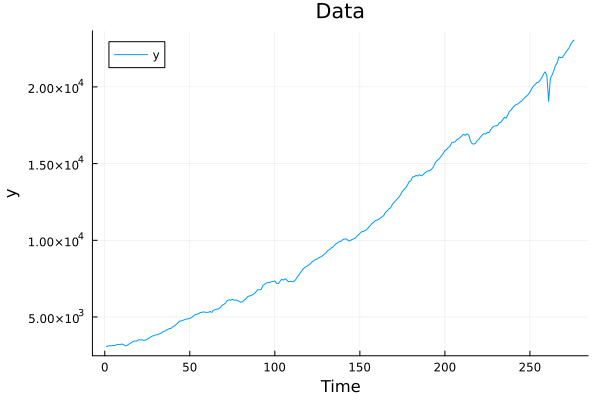

In [80]:
    # Load data 
    data = CSV.read("data.csv", DataFrame)

    # display data
    display(data)

    # plot data
    plot(data[!,:y], label="y", title="Data", xlabel="Time", ylabel="y", legend=:topleft)



## Model & Priors

In [81]:


model_name, θ_elements, α_elements, θ_true, prior_info = get_model_spec()
n_chains = 1
prior_info_collection = [prior_info for i in 1:n_chains]
println(θ_true)






[0.5, 0.1, 0.05, 0.01, 0.1]


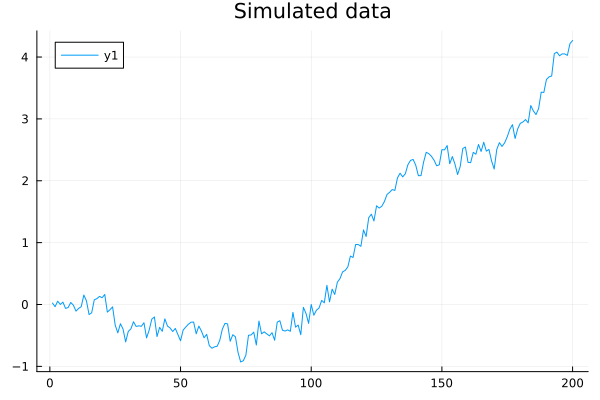

[0.023661453269259017, 0.0, 0.0, 0.0]


4×4 Matrix{Float64}:
 0.01  0.0   0.0   0.0
 0.0   0.01  0.0   0.0
 0.0   0.0   0.01  0.0
 0.0   0.0   0.0   0.01

In [82]:
simulate = true
log_transform = true
standardize = false
X = nothing


y = data.y
y = Matrix(y')
if log_transform
    y = log.(y)
end


if simulate
    n_obs = 200
    y, α = simulate_data(θ_true, n_obs)
    for i in 1:size(y, 1)
        plot(y[i, :], label="y$i")
        display(plot!(title="Simulated data"))
    end
end
    


# Initial states
α0 = zeros(length(α_elements))
α0[1] = y[1]
println(α0)
if simulate == false && log_transform == false
    P0 = 10000*Matrix{Float64}(I, length(α_elements), length(α_elements))
else
    P0 = 0.01*Matrix{Float64}(I, length(α_elements), length(α_elements))
end

Particles: 500 | Mean log likelihood: 111.1024525510963 | Std log likelihood: 3.957554065176746 | Mean time: 0.039882585
Particles: 1000 | Mean log likelihood: 113.42396349405274 | Std log likelihood: 1.6287938167488027 | Mean time: 0.07823211
Particles: 2000 | Mean log likelihood: 113.5186880147251 | Std log likelihood: 1.1391847240579909 | Mean time: 0.15833775
Log likelihood kalman filter: 114.46353652707309


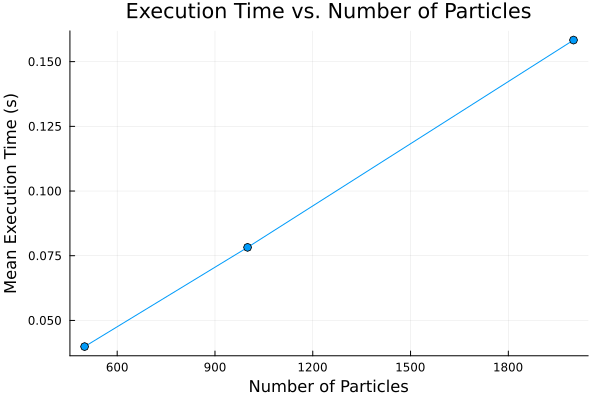

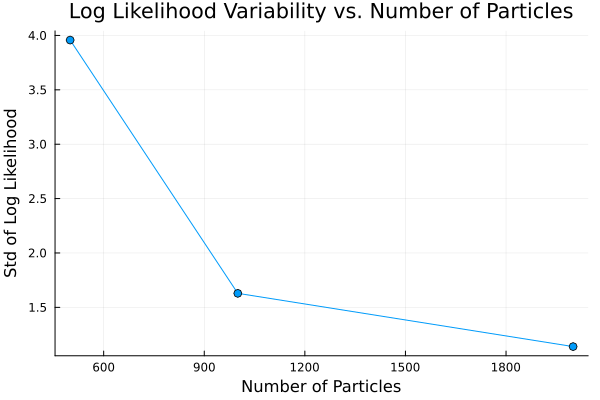

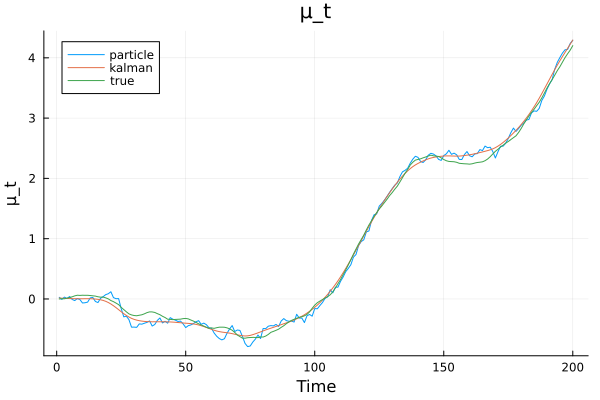

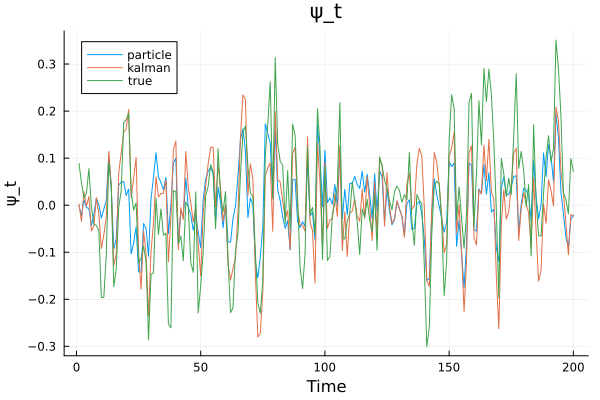

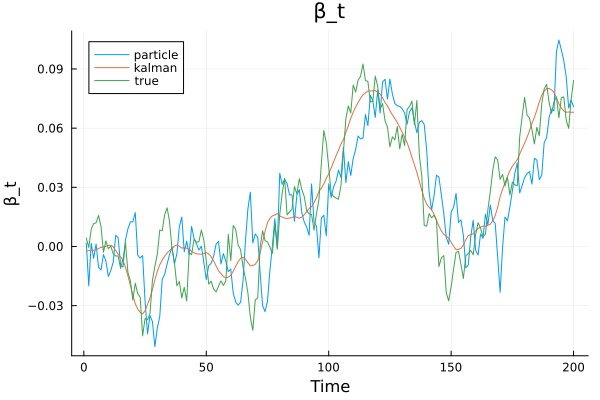

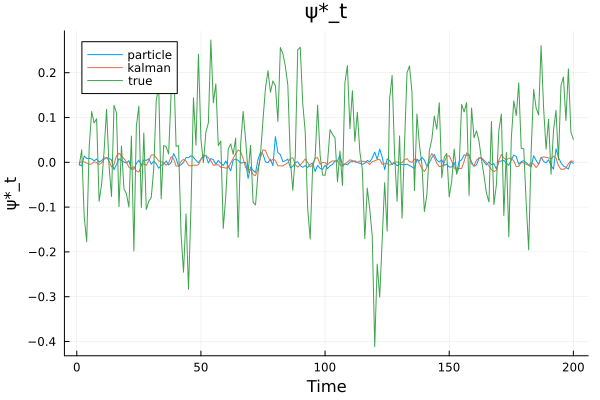

In [83]:
if simulate

    n_particles_values = [500, 1000, 2000]
    num_runs = 20  

    mean_times = zeros(length(n_particles_values))
    mean_logL = zeros(length(n_particles_values))
    std_logL = zeros(length(n_particles_values))

    # Loop over each particle count
    for (idx, n_particles) in enumerate(n_particles_values)
        logL_runs = zeros(num_runs)
        time_runs = zeros(num_runs)
        for run in 1:num_runs
            # Measure the execution time with @elapsed
            t = @elapsed begin
                log_L_particle, _ = particle_filter(y, θ_true, α0, P0, N_particles=n_particles)
            end
            time_runs[run] = t
            logL_runs[run] = log_L_particle
        end
        mean_times[idx] = mean(time_runs)
        mean_logL[idx] = mean(logL_runs)
        std_logL[idx] = std(logL_runs)
        println("Particles: ", n_particles, 
                " | Mean log likelihood: ", mean_logL[idx],
                " | Std log likelihood: ", std_logL[idx],
                " | Mean time: ", mean_times[idx])
    end

    # Plot execution time vs. number of particles
    p_time = plot(n_particles_values, mean_times,
                  marker=:o,
                  xlabel="Number of Particles",
                  ylabel="Mean Execution Time (s)",
                  title="Execution Time vs. Number of Particles",
                  legend=false)

    # Plot standard deviation of log likelihood vs. number of particles
    p_logL = plot(n_particles_values, std_logL,
                  marker=:o,
                  xlabel="Number of Particles",
                  ylabel="Std of Log Likelihood",
                  title="Log Likelihood Variability vs. Number of Particles",
                  legend=false)

    display(p_time)
    display(p_logL)

    #Run and print the Kalman filter results
    Log_L_kalman, states_kalman, _ = diffuse_kalman_filter(y, X, θ_true, α0, P0)
    println("Log likelihood kalman filter: ", Log_L_kalman)

    # Plot the state trajectories from the particle and Kalman filters
    log_L_particle, states_particle = particle_filter(y, θ_true, α0, P0, N_particles=1000)
    for i in 1:length(α_elements)
        p = plot(states_particle[i, :], label="particle", title=α_elements[i],
                 xlabel="Time", ylabel=α_elements[i], legend=:topleft)
        plot!(p, states_kalman[i, :], label="kalman")
        plot!(p, α[i, :], label="true")
        display(p)
    end
end


## Estiamtion

In [84]:
do_MCMC = true
do_MLE = false
forecast_in_sample = 16
forecast_out_sample = 0

0

## MCMC

In [85]:
# θ_chain_all, θ_chain_init_all, α_draws_all = MCMC_estimation_parallel(y_std,X, prior_info_collection, α0, P0;
#                                    filter_type="kalman",
#                                    iter_init=20000,
#                                    burn_init=10000,
#                                    iter_rec=10000,
#                                    burn_rec=5000,
#                                    ω=1.0,
#                                    target_low=0.25,
#                                    target_high=0.35,
#                                    n_chains=n_chains)


Starting chain 1 ...
Chain 1, Initial Parameters: [0.8860741635826359, 2.6028265376874904, 4.789420622909864, 1.5656017060350513, 0.6731874893460349]


Initialization Phase (chain 1) 100%|█████████████████████| Time: 0:00:00


Chain 1, Initialization Acceptance Rate: 33.4%


Recursion Phase (chain 1) 100%|██████████████████████████| Time: 0:00:00


Chains MCMC chain (2000×5×1 Array{Float64, 3}):

Iterations        = 1:1:2000
Number of chains  = 1
Samples per chain = 2000
parameters        = ρ, λ, σ_ϵ, σ_ξ, σ_κ

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           ρ    0.5509    0.2019    0.0739     7.5223    18.8299    1.2531     ⋯
           λ    2.4796    0.6418    0.2958     4.8999    27.5473    2.0647     ⋯
         σ_ϵ    0.1743    0.3823    0.0663    76.2138    16.5324    1.0178     ⋯
         σ_ξ    0.0546    0.2017    0.0483    14.3063    15.1445    1.1231     ⋯
         σ_κ    0.0189    0.0776    0.0201     4.7681    15.4462    2.0315     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           ρ    0.1809    

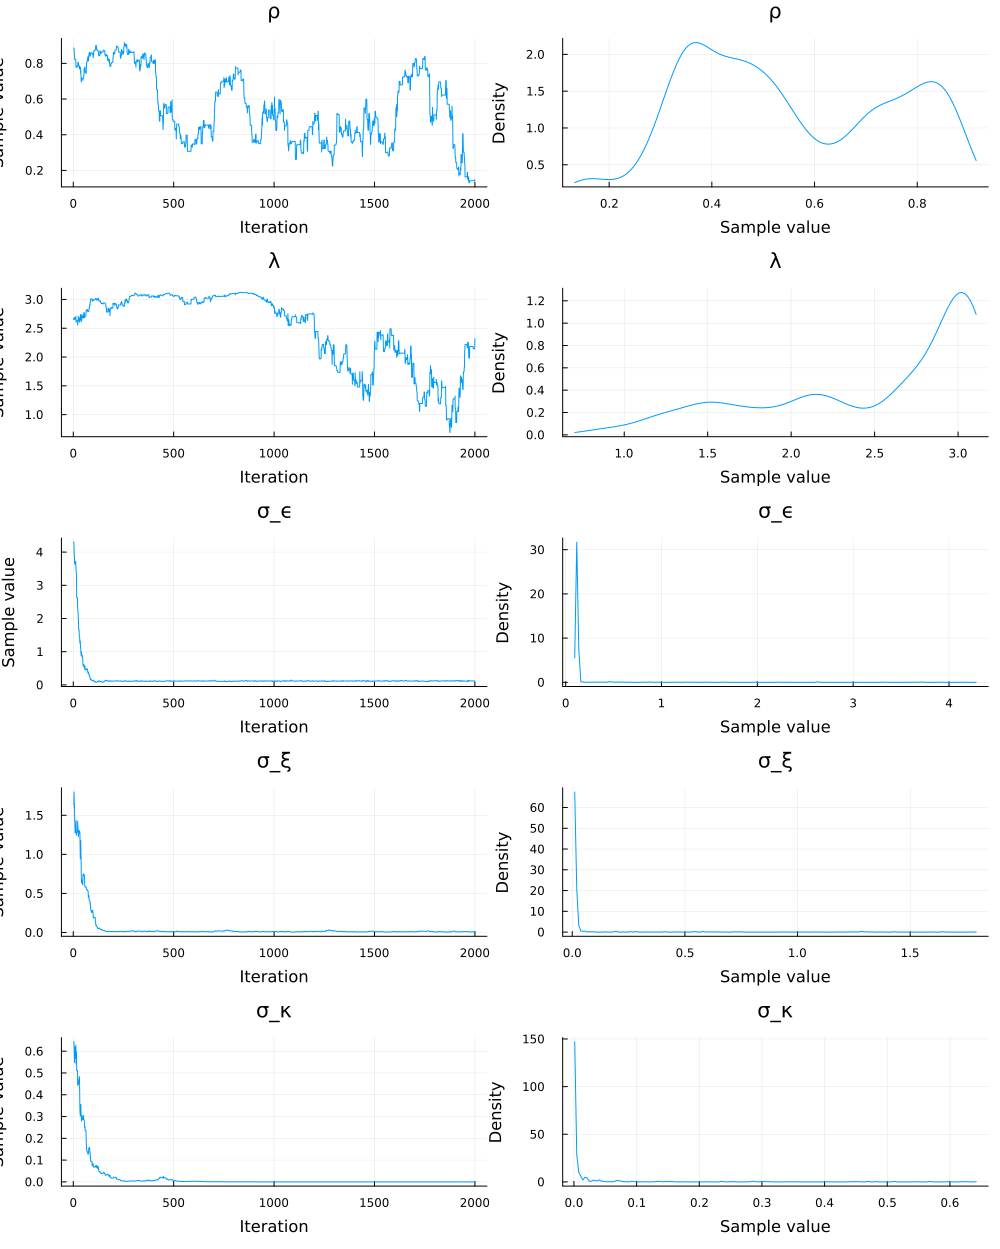

Chains MCMC chain (500×5×1 Array{Float64, 3}):

Iterations        = 1:1:500
Number of chains  = 1
Samples per chain = 500
parameters        = ρ, λ, σ_ϵ, σ_ξ, σ_κ

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           ρ    0.6502    0.0855    0.0184    22.5364    85.6899    1.0145     ⋯
           λ    0.1321    0.1581    0.0814     1.8609    14.1469    1.5769     ⋯
         σ_ϵ    0.0750    0.0082    0.0040     3.7356     8.0866    1.2070     ⋯
         σ_ξ    0.0073    0.0017    0.0005    14.3054    13.7985    1.0905     ⋯
         σ_κ    0.0866    0.0135    0.0038    12.3400    25.5832    1.1989     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           ρ    0.4897    0.5

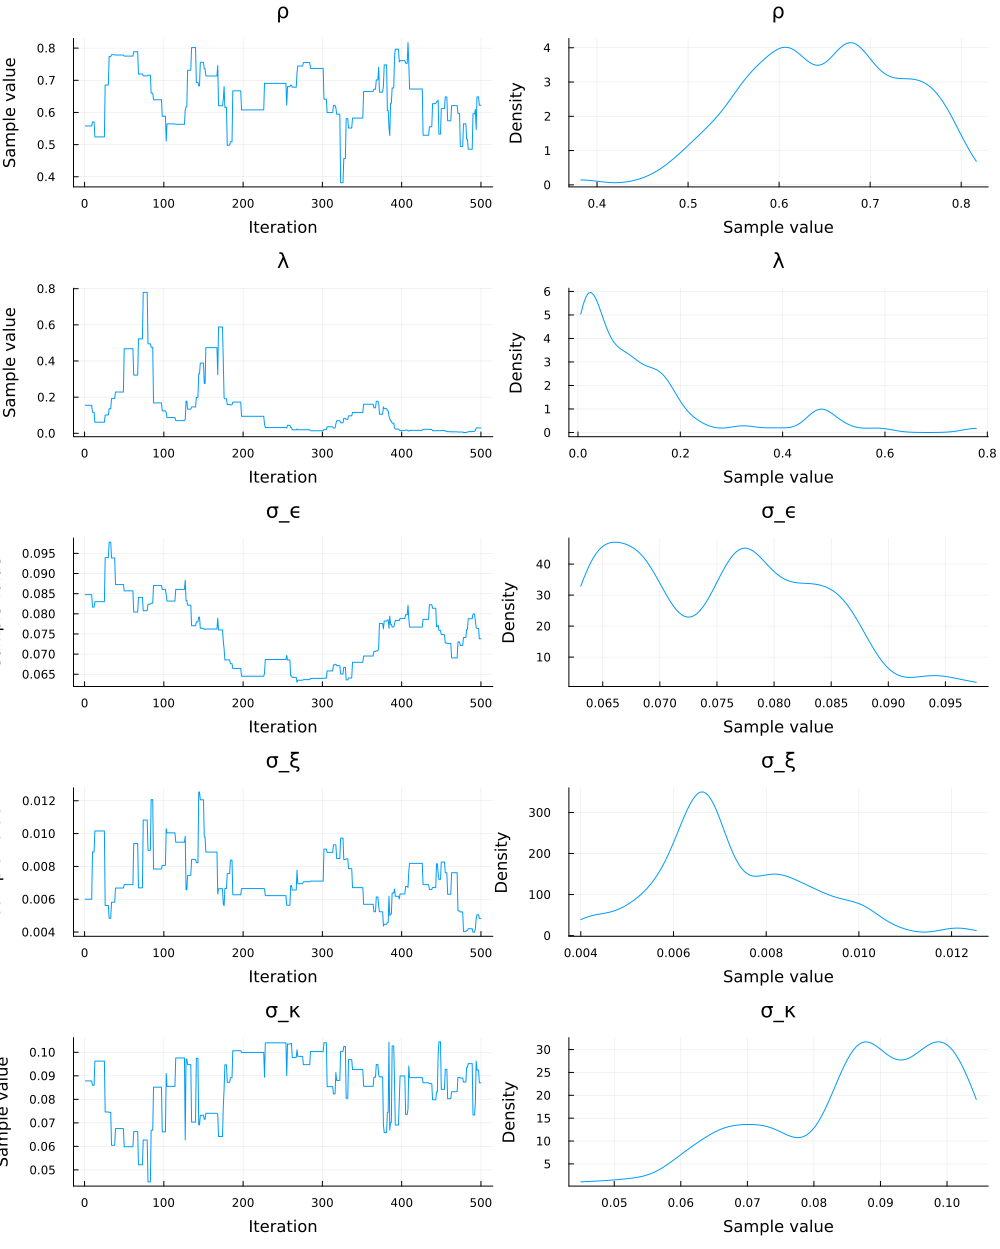

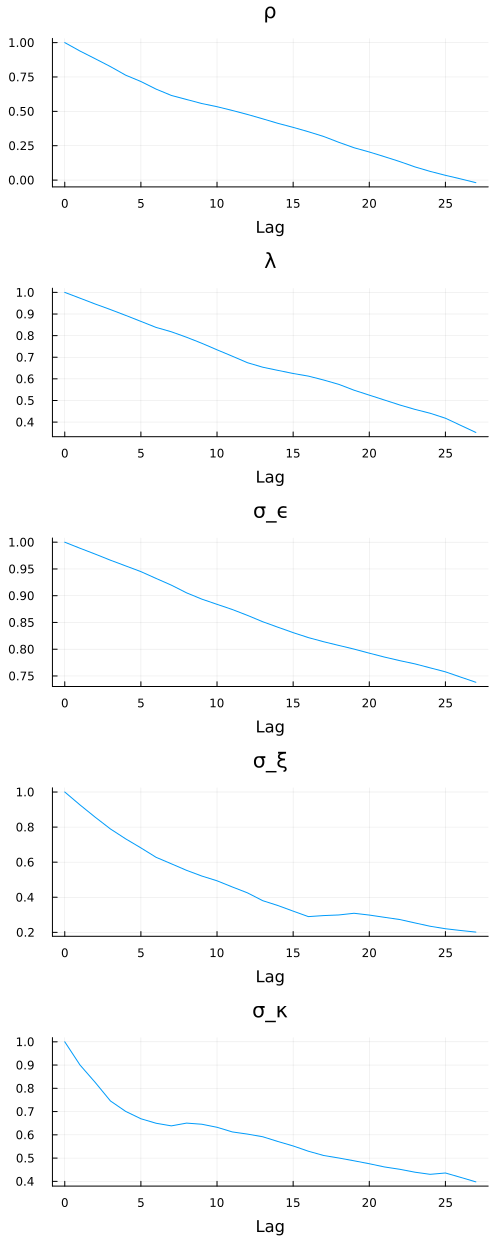

Chain 1, Recursion Acceptance Rate: 37.6%
Chain 1 completed in 1.5160000324249268 seconds.
(500, 5, 1)
(1,)


In [86]:
if do_MCMC

    θ_chain_all, θ_chain_init_all, α_draws_all = MCMC_estimation(y, X, prior_info_collection, α0, P0;
        filter_type = "kalman",
        iter_init = 2000, 
        burn_init = 1000,
        iter_rec = 1000,
        burn_rec = 500,
        ω = 0.01,
        n_chains = n_chains,
        forecast_in_sample = forecast_in_sample,
        forecast_out_sample = forecast_out_sample,
        X_forecast = nothing,
        θ_0 = nothing) # if not θ_0 is given it just draws from prior distributions
    
    println(size(θ_chain_all))
    println(size(α_draws_all))
    
    # MCMC diagnostics
    chain_init = Chains(θ_chain_init_all, θ_elements)
    display(chain_init)
    display(plot(chain_init))
    
    chain_rec = Chains(θ_chain_all, θ_elements)
    display(chain_rec)
    display(plot(chain_rec))
    display(autocorplot(chain_rec))
    
else
    println("Skipping MCMC estimation as do_MCMC is set to false.")
end

## MLE

In [87]:
if do_MLE

    # choose starting values for MLE
    θ_init = zeros(length(θ_elements)) .+ 0.01
    # θ_init = θ_true
    
    # choose optimizers to run (many options see in MLE file. I just use nelder_mead)
    optimizers = [:nelder_mead]
    
    # Run the MLE estimation
    mle_results = mle_estimation(θ_init, y, X, α0, P0, prior_info, optimizers)
    
    # Extract and print estimated parameters for each method and message
    for (opt, res) in mle_results
        θ_est = Optim.minimizer(res)
        println("Optimizer: $opt, Estimated parameters: ", θ_est)
        println("Optimizer: $opt, Converged: ", Optim.converged(res))

    end
    println("true parameters: ", θ_true)
    
    # Get states for MLE results 
    states_mle_results = Dict{Symbol,Any}()
    for (opt, res) in mle_results
        θ_est = Optim.minimizer(res)
        LogL, states_mle, _ = diffuse_kalman_filter(y, X, θ_est, α0, P0; do_smooth=false)
        states_mle_results[opt] = states_mle
    end
else
    println("Skipping MLE estimation as do_MLE is set to false.")
    states_mle_results = Dict{Symbol,Any}()  # empty dict if not computed
end

Skipping MLE estimation as do_MLE is set to false.


Dict{Symbol, Any}()

## Visualize

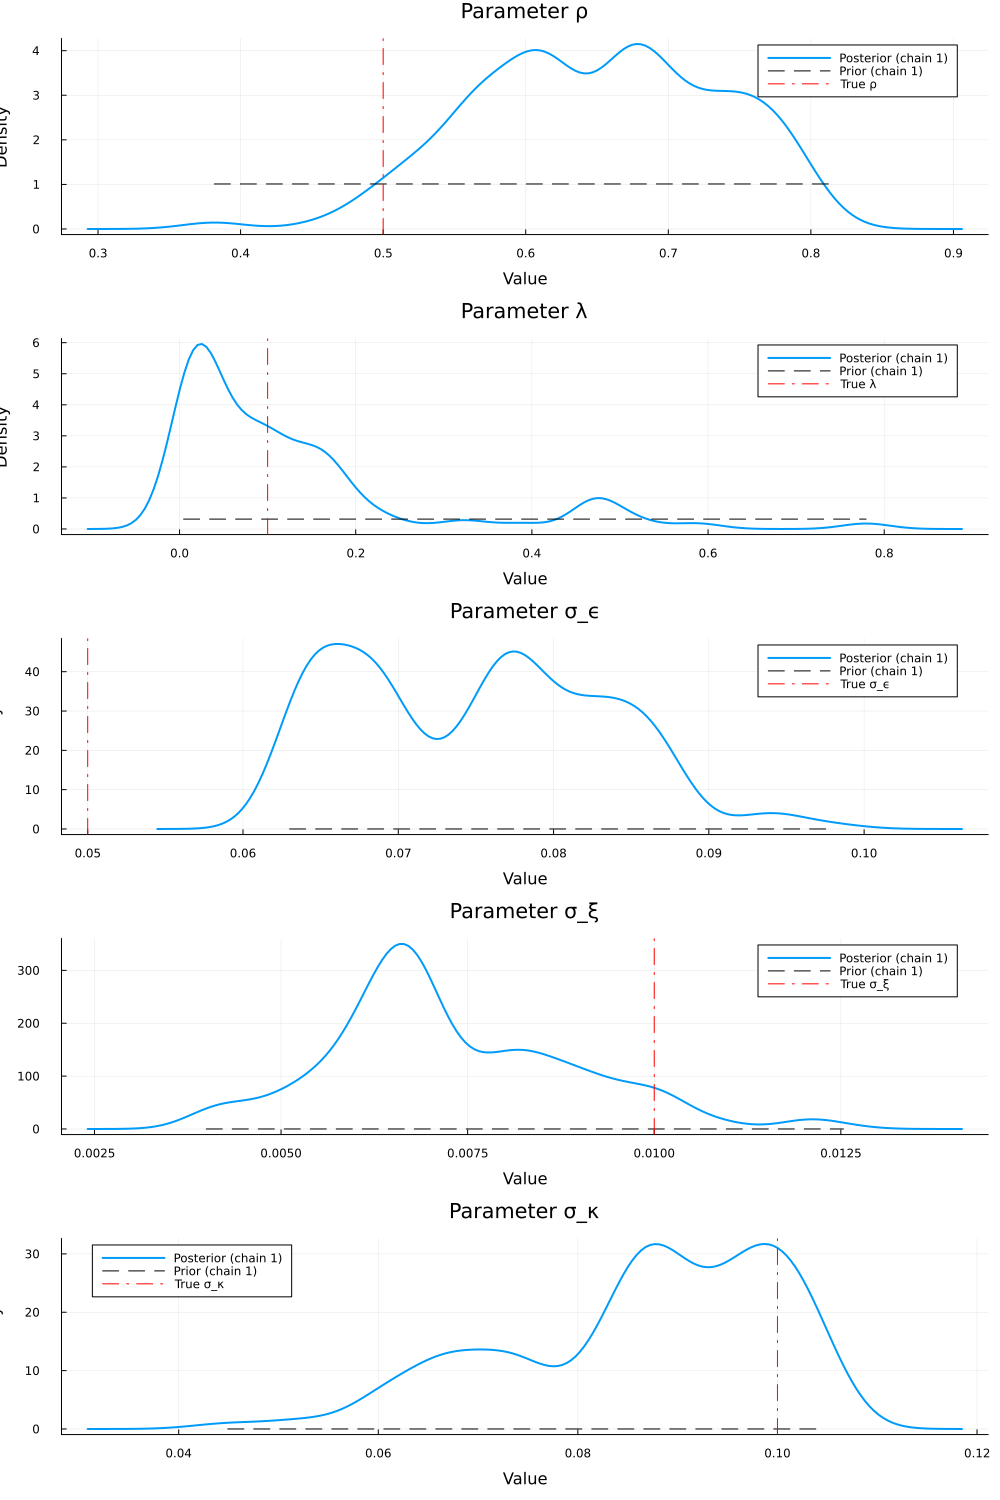

"c:\\Users\\wrc938\\OneDrive - University of Copenhagen\\PhD\\ABC\\Trend-cycle-estimation\\State-Space-Model-Estimation\\main\\plots\\wave_cycle_stochastic_drift_params_log_GDP.png"

In [88]:
# Initialize a vector to store the parameter plots.
plots_vec = []

for i in 1:length(θ_elements)
    p = plot(title = "Parameter $(θ_elements[i])", xlabel = "Value", ylabel = "Density")
    
    # If MCMC was run, plot the posterior density and the corresponding prior for each chain.
    if do_MCMC && θ_chain_all !== nothing
        for j in 1:n_chains
            samples = θ_chain_all[:, i, j]
            density!(p, samples, label = "Posterior (chain $j)", linewidth = 2)
            
            # Define a range for plotting the prior density.
            # xs = range(max(minimum(samples) - 0.5, 0.0), maximum(samples) + 0.5, length = 200)
            xs = range(minimum(samples), maximum(samples), length = 200)
            dist_type = prior_info_collection[j].distributions[i]
            hp1 = prior_info_collection[j].parameters[i, 1]
            hp2 = prior_info_collection[j].parameters[i, 2]
            prior = if dist_type == "uniform"
                Uniform(hp1, hp2)
            elseif dist_type == "beta"
                Beta(hp1, hp2)
            elseif dist_type == "normal"
                Normal(hp1, hp2)
            elseif dist_type == "inverse_gamma"
                InverseGamma(hp1, hp2)
            else
                error("Unknown prior distribution: $dist_type")
            end
            plot!(p, xs, pdf.(prior, xs), label = "Prior (chain $j)", color = :black, linestyle = :dash)
        end
    end
    
    # Add a vertical line for the true parameter value.
    if simulate
        vline!(p, [θ_true[i]], label = "True $(θ_elements[i])", linestyle = :dashdot, color = :red)
    end
  
    
    # Overlay MLE estimates from each optimizer if available.
    if do_MLE && mle_results !== nothing
        for (opt, res) in mle_results
            θ_est = (opt == :slsqp) ? res.minimizer : Optim.minimizer(res)
            vline!(p, [θ_est[i]], label = "MLE $(θ_elements[i]) ($opt)", color = :green)
        end
    end
    
    # Append the current plot to the vector.
    push!(plots_vec, p)
end

# Combine all plots into one image and display it.
if !isempty(plots_vec)
    combined_plot = plot(plots_vec..., layout = (length(θ_elements), 1), size = (1000, 300 * length(θ_elements)))
    display(combined_plot)
end

# Save the combined image if MCMC was run.
if do_MCMC
    if log_transform == true
        savefig(combined_plot, "plots/$(model_name)_params_log_GDP.png")
    else
        savefig(combined_plot, "plots/$(model_name)_params.png")
    end
end


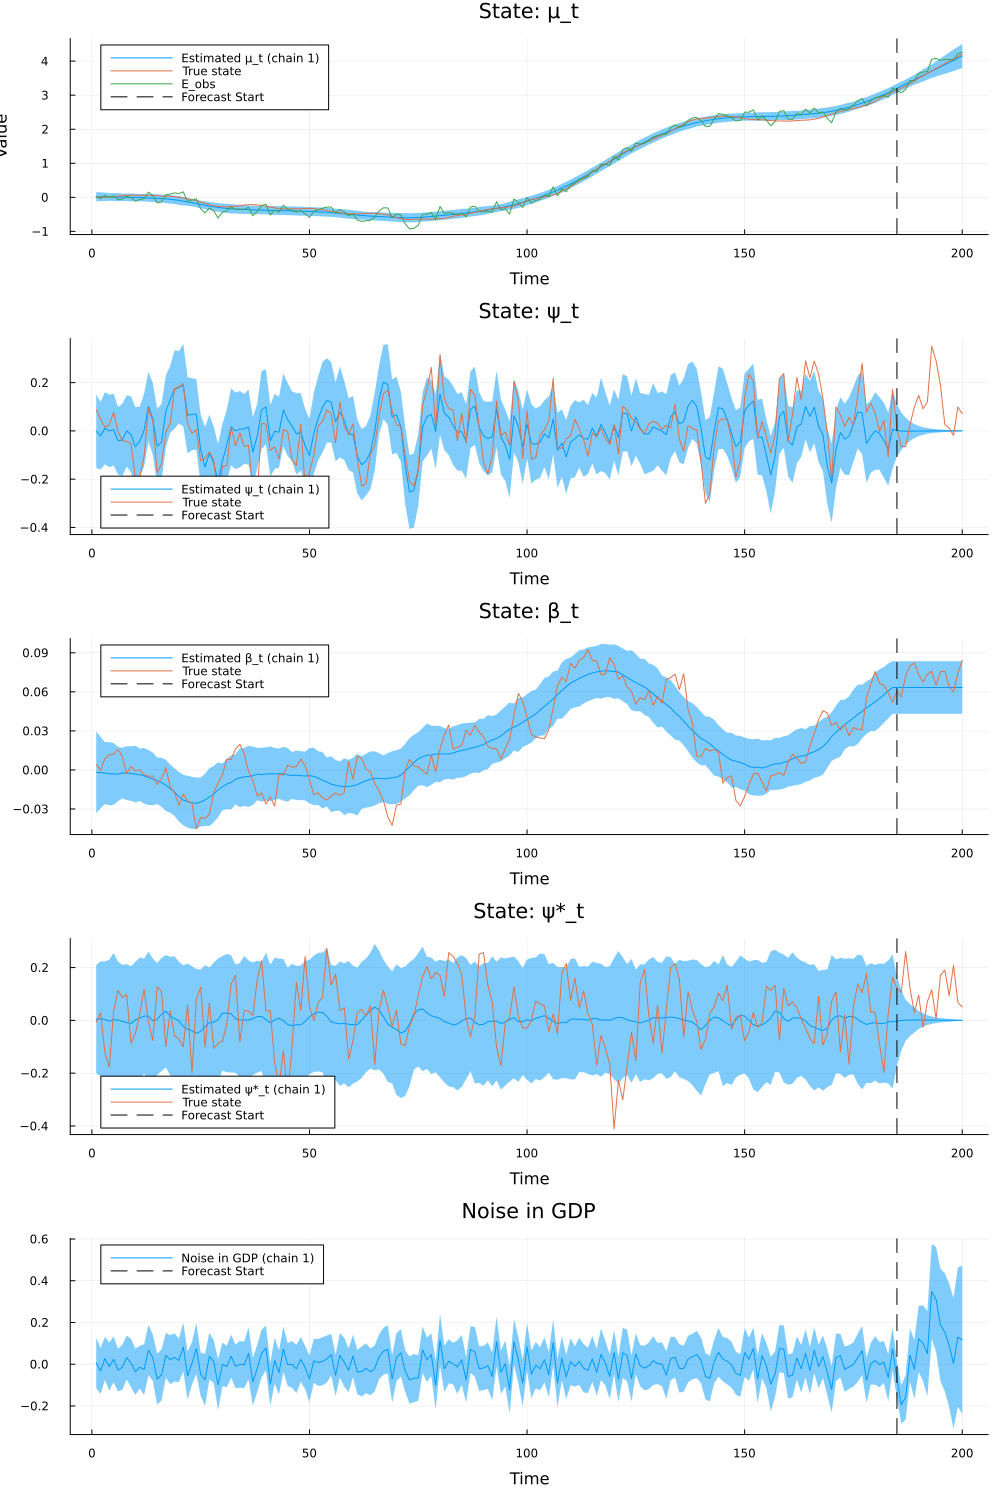

"c:\\Users\\wrc938\\OneDrive - University of Copenhagen\\PhD\\ABC\\Trend-cycle-estimation\\State-Space-Model-Estimation\\main\\plots\\wave_cycle_stochastic_drift_states_log_GDP.png"

In [89]:
# ----- State Plotting -----
plots_vec = []

# Determine the number of states from the state vector.
n_states = length(α_elements)

# Determine forecast start index based on observed data length and forecast lengths.
T_obs = size(y, 2)
forecast_total = forecast_in_sample + forecast_out_sample
if forecast_total > 0
    forecast_start = T_obs - forecast_in_sample + 1
end

for i in 1:(n_states + 1)
    if i == n_states + 1
        # --- Noise Plot ---
        p = plot(title = "Noise in GDP", xlabel = "Time", ylabel = "Value")
        # Compute noise for every MCMC draw for each chain.
        if do_MCMC && α_draws_all !== nothing
            n_chains = length(α_draws_all)  # Note: α_draws_all is now a vector (one per chain)
            for ch in 1:n_chains
                # Get the vector of matrices for the current chain.
                chain_draws = α_draws_all[ch]
                draws_count = length(chain_draws)
                state_dim, time_dim = size(chain_draws[1])
                # Convert to a 3D array with dimensions: (draw, state, time)
                α_array = Array{Float64}(undef, draws_count, state_dim, time_dim)
                for d in 1:draws_count
                    α_array[d, :, :] = chain_draws[d]
                end

                # Limit the time dimension to observed data (exclude out-of-sample forecast part)
                t_idx = 1:(time_dim - forecast_out_sample)
                # Compute noise: assume noise = y[1, :] - (state 1 + state 2)
                noise_draws = reshape(y[1, t_idx], 1, length(t_idx)) .- (α_array[:, 1, t_idx] .+ α_array[:, 2, t_idx])
                noise_mean = dropdims(mean(noise_draws, dims=1), dims=1)
                noise_ci = mapslices(x -> quantile(x, [0.025, 0.975]), noise_draws, dims=1)
                plot!(p, noise_mean,
                      ribbon = (noise_ci[2, :] .- noise_mean),
                      label = "Noise in GDP (chain $ch)")
            end
        end
        # Add vertical line at forecast start if forecast was performed.
        if forecast_total > 0
            vline!(p, [forecast_start], linestyle = :dash, color = :black, label = "Forecast Start")
        end
    else
        # --- State Plot ---
        p = plot(title = "State: $(α_elements[i])", xlabel = "Time", ylabel = "Value")
        # Overlay MCMC state draws if available.
        if do_MCMC && α_draws_all !== nothing
            n_chains = length(α_draws_all)
            for ch in 1:n_chains
                chain_draws = α_draws_all[ch]
                draws_count = length(chain_draws)
                state_dim, time_dim = size(chain_draws[1])
                # Convert vector-of-matrices to a 3D array.
                α_array = Array{Float64}(undef, draws_count, state_dim, time_dim)
                for d in 1:draws_count
                    α_array[d, :, :] = chain_draws[d]
                end
                # Compute mean over draws (first dimension).
                α_mean = dropdims(mean(α_array, dims=1), dims=1)
                # Compute 95% quantiles over draws.
                α_ci = mapslices(x -> quantile(x, [0.025, 0.975]), α_array, dims=1)
                plot!(p, α_mean[i, :],
                      ribbon = (α_ci[2, i, :] .- α_mean[i, :]),
                      label = "Estimated $(α_elements[i]) (chain $ch)")
            end
        end

        # Overlay MLE state estimates if available.
        if do_MLE && !isempty(states_mle_results)
            for (opt, states_mle) in states_mle_results
                plot!(p, states_mle[i, :], label = "MLE $(α_elements[i]) ($opt)")
            end
        end

        # Overlay the true state if simulation is enabled.
        if simulate
            plot!(p, α[i, :], label = "True state")
        end

        # Overlay observed data (only for the first state).
        if i == 1
            plot!(p, y[1, :], label = "E_obs")
        end

        # Add vertical line at forecast start if forecast was performed.
        if forecast_total > 0
            vline!(p, [forecast_start], linestyle = :dash, color = :black, label = "Forecast Start")
        end
    end

    push!(plots_vec, p)
end

total_plots = length(plots_vec)
combined_plot = plot(plots_vec..., layout = (total_plots, 1), size = (1000, 300 * total_plots))
display(combined_plot)

# Save image
if log_transform == true
    savefig(combined_plot, "plots/$(model_name)_states_log_GDP.png")
else
    savefig(combined_plot, "plots/$(model_name)_states.png")
end


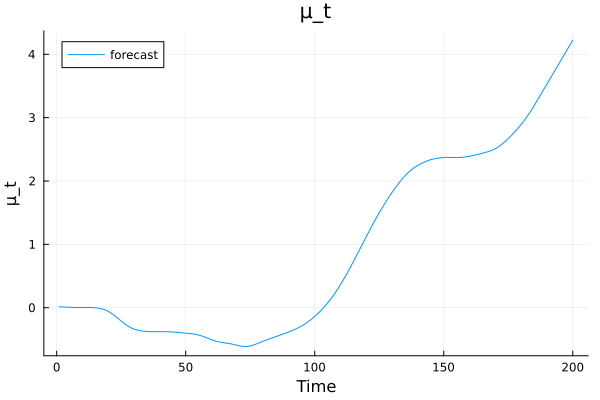

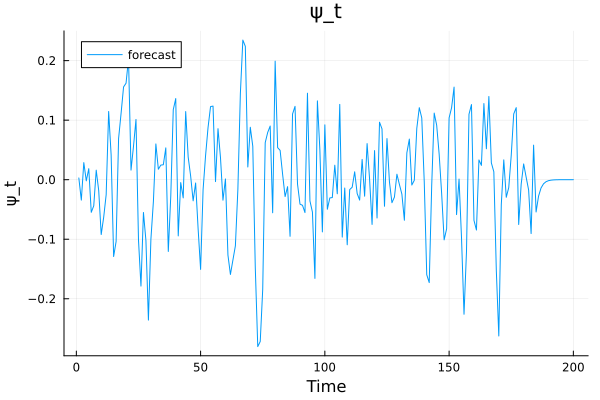

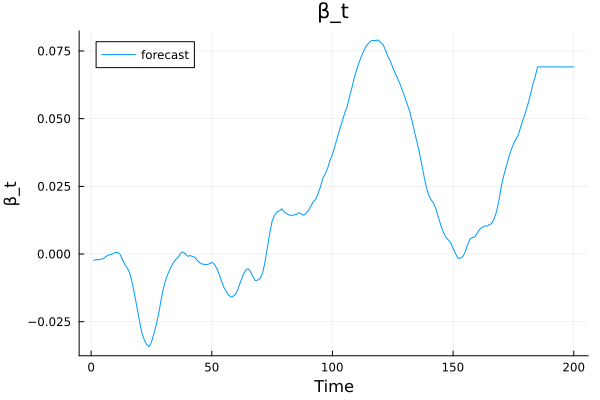

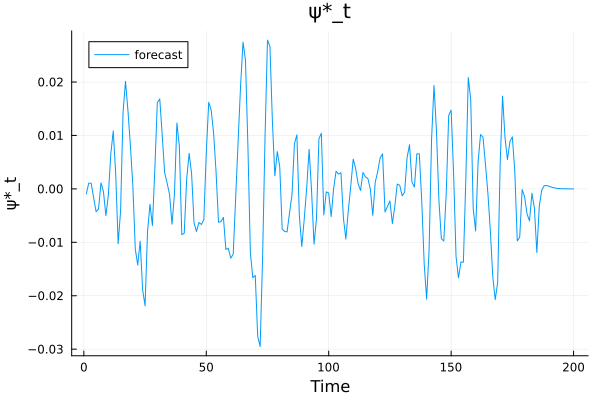

In [90]:
# try forecast

_, α_forecast, _ = diffuse_kalman_filter(y, X, θ_true, α0, P0; 
                                do_smooth = true, 
                                do_sim_smooth = false, 
                                forecast_in_sample= 15,
                                forecast_out_sample = 0)

# plot α_forecast
for i in 1:length(α_elements)
    p = plot(α_forecast[i, :], label="forecast", title=α_elements[i],
             xlabel="Time", ylabel=α_elements[i], legend=:topleft)
    display(p)
end